In [17]:
import sys 
sys.path.insert(0, "/forecaster/src")

from pathlib import Path 

import matplotlib.pyplot as plt 
import numpy as np 
import jax.numpy as jnp 
from jax import jit, grad, vmap
import jax.random as jnpr 
from statsmodels.tsa.stattools import acf 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso, Ridge

from dataset import ForecastingConfig, ForecastingDataset, SegmentationConfig, SegmentationDataset
from metrics import rms, percentage_error
from models import last_value, RunningAverage

In [2]:
smooth: callable = lambda x, order=10: np.convolve(np.ones(order)/order, x, mode='same')

In [3]:
data_config = SegmentationConfig(
    data_source=Path("/forecaster/data/aggregated.pkl"), 
)
segmentation_dataset = SegmentationDataset(data_config) 

2023-08-15 18:24:11,148 INFO Deserialized source data from: /forecaster/data/aggregated.pkl


## Figure 1: Basic Signal Statistics

First figure just displays some raw signals, and their associated seasonal decomposition and autocorrelation functions. 

In [4]:
segmentation_dataset.data[0].shape

(1, 1269)

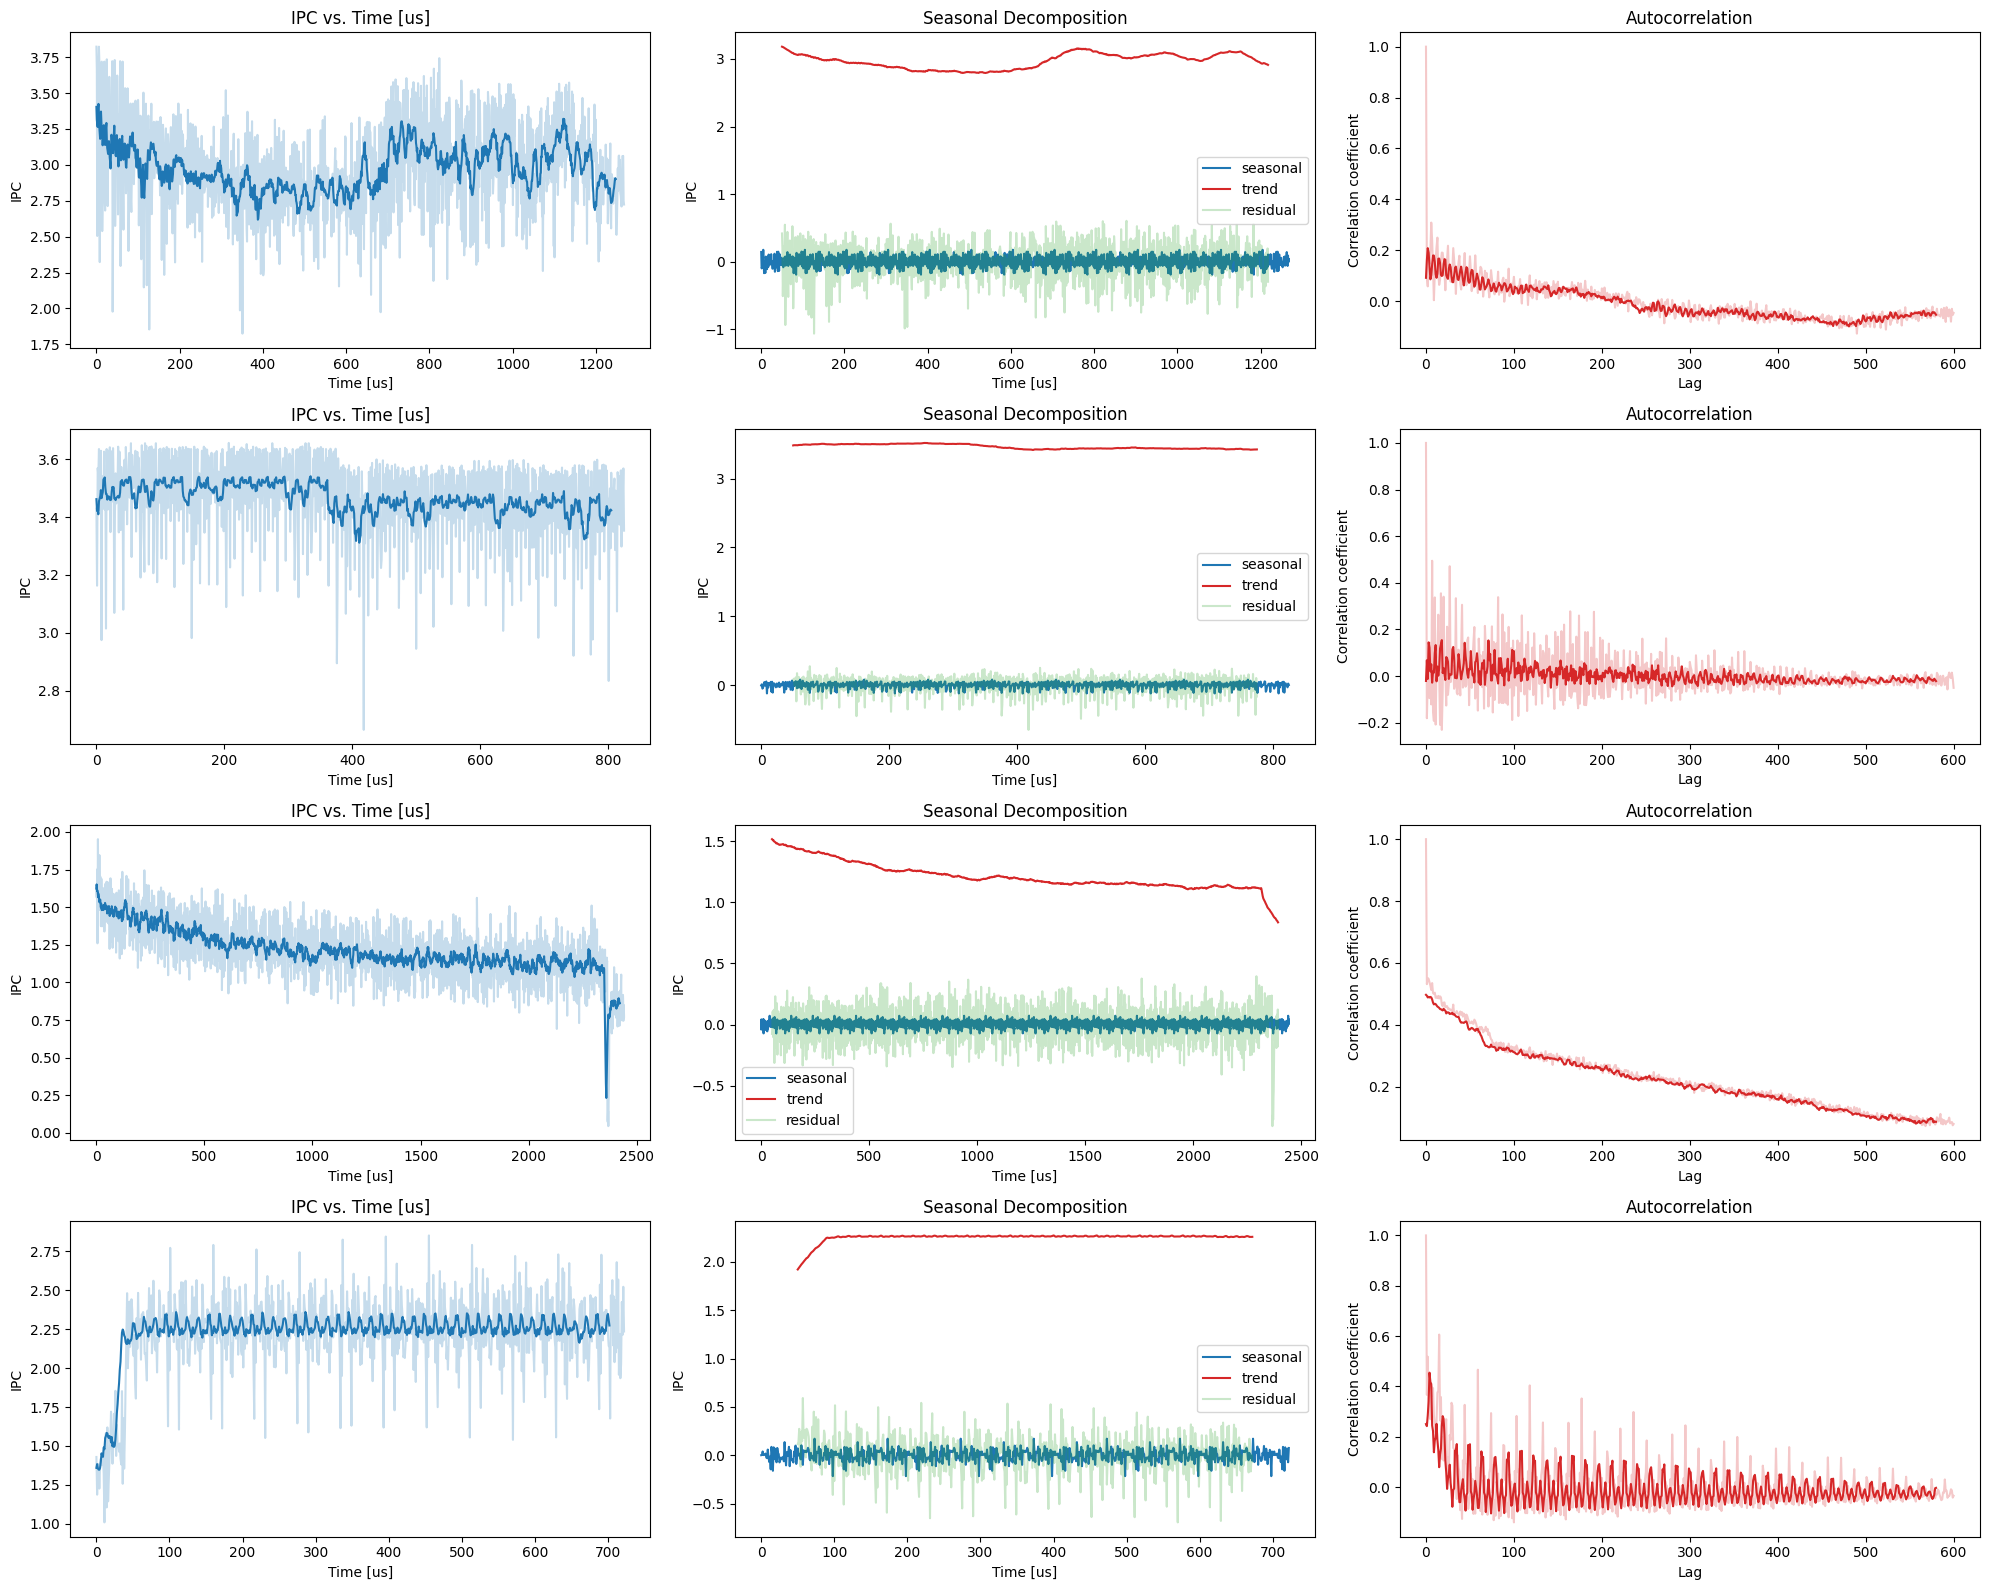

In [5]:
%matplotlib inline 

fig, axes = plt.subplots(nrows=4, ncols=3)

data_indices = [0, 9, 10, 6]

for i, axs in enumerate(axes): 
    axs[0].set_title("IPC vs. Time [us]")

    axs[0].plot(segmentation_dataset.data[data_indices[i]][0], c="tab:blue", alpha=0.25)
    axs[0].plot(smooth(segmentation_dataset.data[data_indices[i]][0])[10:-10], c="tab:blue")
    axs[0].set_xlabel("Time [us]")
    axs[0].set_ylabel("IPC")

    result = seasonal_decompose(segmentation_dataset.data[data_indices[i]][0], period=100)
    axs[1].plot(result.seasonal, label="seasonal", c="tab:blue")
    axs[1].plot(result.trend, label="trend", c="tab:red")
    axs[1].plot(result.resid, label="residual", c="tab:green", alpha=0.25)
    axs[1].set_title("Seasonal Decomposition")
    axs[1].set_xlabel("Time [us]")
    axs[1].set_ylabel("IPC")
    axs[1].legend()

    autocorrelation = acf(segmentation_dataset.data[data_indices[i]][0], nlags=600)
    axs[2].plot(autocorrelation, c="tab:red", alpha=0.25)
    axs[2].plot(smooth(autocorrelation, order=3)[10:-10], c="tab:red")
    axs[2].set_xlabel("Lag")
    axs[2].set_title("Autocorrelation")
    axs[2].set_ylabel("Correlation coefficient")

fig.set_size_inches((20, 16))

plt.tight_layout()

#save_path = "/forecaster/figures/seasonal_decomposition.pdf"
#plt.savefig(save_path)
#plt.close()
plt.show()

In [6]:
data_config = ForecastingConfig(
    data_source=Path("/forecaster/data/aggregated_new.pkl"), 
    predictors="ipc", 
    aggregate_benchmarks=True
)
dataset = ForecastingDataset(data_config) 

train_inputs: np.ndarray = dataset.data["train_predictors"]
train_targets: np.ndarray = dataset.data["train_targets"]
validation_inputs: np.ndarray = dataset.data["validation_predictors"]
validation_targets: np.ndarray = dataset.data["validation_targets"]

2023-08-15 18:24:25,496 INFO Starting setup...
2023-08-15 18:24:25,780 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 18:24:25,803 INFO Aggregating predictors and targets across benchmarks
2023-08-15 18:24:25,813 INFO Finished setup...


## Forecasting

### Baselines

In [7]:
results: dict = {} 

In [8]:
validation_inputs.shape

(1927, 1, 3)

In [9]:
validation_predictions: np.ndarray = vmap(last_value)(validation_inputs[:, -1, :])
results["last_value"] = percentage_error(validation_predictions, validation_targets)
results

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


{'last_value': Array(43.07035, dtype=float32)}

In [10]:
model = RunningAverage()
validation_predictions: np.ndarray = model.evaluate(validation_inputs[:, -1, :])
results["running_average"] = percentage_error(validation_predictions, validation_targets)
results

{'last_value': Array(43.07035, dtype=float32),
 'running_average': Array(32.705795, dtype=float32)}

### Linear Models

0.599508870165032

In [11]:
A: np.ndarray = train_inputs.reshape(train_inputs.shape[0], -1) 
b: np.ndarray = train_targets
x: np.ndarray = np.linalg.solve(A.T @ A, A.T @ b)
validation_predictions = validation_inputs.reshape(validation_inputs.shape[0], -1) @ x 
results["linear_lstsq"] = percentage_error(validation_predictions, validation_targets)
results

{'last_value': Array(43.07035, dtype=float32),
 'running_average': Array(32.705795, dtype=float32),
 'linear_lstsq': Array(7.3252163, dtype=float32)}

In [41]:
data_config = ForecastingConfig(
    data_source=Path("/forecaster/data/aggregated_new.pkl"), 
    predictors="", 
    aggregate_benchmarks=True
)
dataset = ForecastingDataset(data_config) 

train_inputs: np.ndarray = dataset.data["train_predictors"]
train_targets: np.ndarray = dataset.data["train_targets"]
validation_inputs: np.ndarray = dataset.data["validation_predictors"]
validation_targets: np.ndarray = dataset.data["validation_targets"]

def add_random(key: jnp.ndarray, num_new_features: int, x: jnp.ndarray) -> jnp.ndarray: 
    num_samples, num_features, feature_dimension = x.shape 
    R: jnp.ndarray = jnpr.choice(key, jnp.array([-1.0, 1.0]), shape=(num_new_features, num_features))
    random_features: jnp.ndarray = R[None, ...] @ x
    return np.concatenate((x, random_features), axis=1)

add_bias: callable = lambda X: np.hstack((np.ones((X.shape[0], 1)), X))
key: jnp.ndarray = jnpr.PRNGKey(0)

A: np.ndarray = train_inputs.reshape(train_inputs.shape[0], -1) 
b: np.ndarray = train_targets
x: np.ndarray = np.linalg.solve(A.T @ A, A.T @ b)
validation_predictions = validation_inputs.reshape(validation_inputs.shape[0], -1) @ x 
results["linear_lstsq_all_random"] = percentage_error(validation_predictions, validation_targets)
results


2023-08-15 18:42:08,356 INFO Starting setup...
2023-08-15 18:42:08,641 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 18:42:08,666 INFO Aggregating predictors and targets across benchmarks
2023-08-15 18:42:08,676 INFO Finished setup...


{'last_value': Array(43.07035, dtype=float32),
 'running_average': Array(32.705795, dtype=float32),
 'linear_lstsq': Array(7.3252163, dtype=float32),
 'linear_lstsq_all_random': Array(6.80191, dtype=float32),
 'lasso': Array(42.450638, dtype=float32),
 'ridge': Array(6.7080555, dtype=float32)}

In [42]:
x.shape

(33, 1)

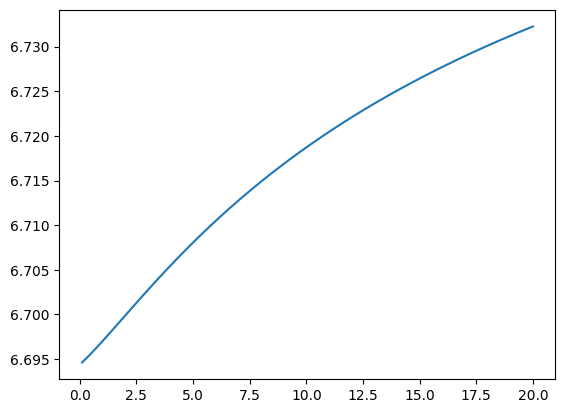

In [30]:
alphas = np.linspace(0.1, 20.0, num=100)
errors = [] 

for alpha in alphas: 
    ridge = Ridge(alpha=alpha, max_iter=10_000)
    ridge.fit(A, b)
    validation_predictions = ridge.predict(validation_inputs.reshape(validation_inputs.shape[0], -1))
    errors.append(percentage_error(validation_predictions, validation_targets))

plt.figure() 
plt.plot(alphas, errors) 
plt.show()

In [68]:
results

plt.figure(figsize=(8, 5)) 
plt.title("Forecasting Error vs. Model Size (number of features)")
plt.xlabel("Model size [number of parameters]")
plt.ylabel("Percentage Error [%]")
plt.scatter(0.0, results["last_value"], label="Last Value")
plt.scatter(2.0, results["running_average"], label="Running Average")
plt.scatter(4.0, results["linear_lstsq"], label="Linear Autoregressive")
plt.scatter(4.0, results["linear_lstsq"], label="Linear Autoregressive")
plt.scatter(33.0, results["linear_lstsq_all_random"], label="Linear Autoregressive (all features)")
plt.legend()
plt.ylim(0, 100)

save_path = "/forecaster/figures/error_vs_size.pdf"
plt.savefig(save_path)
plt.close()


In [48]:
history_size = list(range(1, 23))
percentage_errors = [] 

for size in history_size: 
    data_config = ForecastingConfig(
        data_source=Path("/forecaster/data/aggregated_new.pkl"), 
        model_memory=size, 
        aggregate_benchmarks=True
    )
    dataset = ForecastingDataset(data_config) 

    train_inputs: np.ndarray = dataset.data["train_predictors"]
    train_targets: np.ndarray = dataset.data["train_targets"]
    validation_inputs: np.ndarray = dataset.data["validation_predictors"]
    validation_targets: np.ndarray = dataset.data["validation_targets"]

    A: np.ndarray = train_inputs.reshape(train_inputs.shape[0], -1) 
    b: np.ndarray = train_targets
    x: np.ndarray = np.linalg.solve(A.T @ A, A.T @ b)
    validation_predictions = validation_inputs.reshape(validation_inputs.shape[0], -1) @ x 
    percentage_errors.append(percentage_error(validation_predictions, validation_targets))


2023-08-15 18:46:35,377 INFO Starting setup...
2023-08-15 18:46:35,697 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 18:46:35,757 INFO Aggregating predictors and targets across benchmarks
2023-08-15 18:46:35,768 INFO Finished setup...
2023-08-15 18:46:35,778 INFO Starting setup...
2023-08-15 18:46:36,078 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 18:46:36,120 INFO Aggregating predictors and targets across benchmarks
2023-08-15 18:46:36,130 INFO Finished setup...
2023-08-15 18:46:36,132 INFO Starting setup...
2023-08-15 18:46:36,334 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 18:46:36,356 INFO Aggregating predictors and targets across benchmarks
2023-08-15 18:46:36,366 INFO Finished setup...
2023-08-15 18:46:36,369 INFO Starting setup...
2023-08-15 18:46:36,679 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 18:46:36,697 INFO Aggregating 

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].set_title("Forecasting Error [%] vs. Model memory length")
axs[0].scatter(1.0, results["last_value"], label="Last Value")
axs[0].scatter(1.0, results["running_average"], label="Running Average")
axs[0].scatter(history_size, percentage_errors, label="Linear Autoregressive")
axs[0].set_ylim(0, 100)
axs[0].set_xlabel("Model memory length")
axs[0].set_ylabel("Percentage Error [%]")
axs[0].legend()

axs[1].set_title("Forecasting Error [%] vs. Model memory length")
axs[1].scatter(history_size, percentage_errors, c="tab:green", label="Linear Autoregressive")
axs[1].plot(history_size, percentage_errors, c="tab:green", alpha=0.25)
axs[1].set_ylim(5, 10)
axs[1].set_xlabel("Model memory length")
axs[1].set_ylabel("Percentage Error [%]")
axs[1].legend()

fig.set_size_inches(15, 5)
save_path = "/forecaster/figures/error_vs_memory_length.pdf"
plt.savefig(save_path)
plt.close()

### Linear Model -- Analysis 

1. Error vs. Number of features 
2. Error vs. memory length 
3. Error vs. timescale 

Starting with error vs. number of features 

In [12]:
def add_random(key: jnp.ndarray, num_new_features: int, x: jnp.ndarray) -> jnp.ndarray: 
    num_samples, num_features, feature_dimension = x.shape 
    R: jnp.ndarray = jnpr.choice(key, jnp.array([-1.0, 1.0]), shape=(num_new_features, num_features))
    random_features: jnp.ndarray = R[None, ...] @ x
    return np.concatenate((x, random_features), axis=1)

add_bias: callable = lambda X: np.hstack((np.ones((X.shape[0], 1)), X))
key: jnp.ndarray = jnpr.PRNGKey(0)

In [71]:
x = np.arange(9).reshape(3, 3)

bias = np.ones((x.shape[0], 1))
np.hstack((bias, x))


array([[1., 0., 1., 2.],
       [1., 3., 4., 5.],
       [1., 6., 7., 8.]])

In [13]:
key: jnp.ndarray = jnpr.PRNGKey(0)

In [57]:
x = jnp.arange(9).reshape(1, 3, 3)

In [58]:
x

Array([[[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]], dtype=int32)

In [67]:
r = add_random(key, 2, x)
r

Array([[[  9.,  10.,  11.],
        [ -9., -12., -15.]]], dtype=float32)

In [66]:
np.concatenate((x, r), axis=1)

array([[[  0.,   1.,   2.],
        [  3.,   4.,   5.],
        [  6.,   7.,   8.],
        [  9.,  10.,  11.],
        [ -9., -12., -15.]]])

Error vs. Memory length 

In [91]:
memory_lengths = list(range(3, 10))
percentage_errors = [] 

for m in memory_lengths: 
    data_config = ForecastingConfig(
        data_source=Path("/forecaster/data/aggregated_new.pkl"), 
        predictors="operations", 
        model_memory=m, 
        aggregate_benchmarks=True
    )
    dataset = ForecastingDataset(data_config) 

    train_inputs: np.ndarray = dataset.data["train_predictors"]
    train_targets: np.ndarray = dataset.data["train_targets"]
    validation_inputs: np.ndarray = dataset.data["validation_predictors"]
    validation_targets: np.ndarray = dataset.data["validation_targets"]
    
    A: np.ndarray = train_inputs.reshape(train_inputs.shape[0], -1) 
    b: np.ndarray = train_targets
    x: np.ndarray = np.linalg.solve(A.T @ A, A.T @ b)
    validation_predictions = validation_inputs.reshape(validation_inputs.shape[0], -1) @ x 
    percentage_errors.append(percentage_error(validation_predictions, validation_targets))

2023-08-15 14:36:19,287 INFO Starting setup...
2023-08-15 14:36:19,632 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 14:36:19,656 INFO Aggregating predictors and targets across benchmarks
2023-08-15 14:36:19,667 INFO Finished setup...
2023-08-15 14:36:19,670 INFO Starting setup...
2023-08-15 14:36:20,062 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 14:36:20,084 INFO Aggregating predictors and targets across benchmarks
2023-08-15 14:36:20,098 INFO Finished setup...
2023-08-15 14:36:20,101 INFO Starting setup...
2023-08-15 14:36:20,319 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 14:36:20,335 INFO Aggregating predictors and targets across benchmarks
2023-08-15 14:36:20,346 INFO Finished setup...
2023-08-15 14:36:20,349 INFO Starting setup...
2023-08-15 14:36:20,566 INFO Deserialized source data from: /forecaster/data/aggregated_new.pkl
2023-08-15 14:36:20,580 INFO Aggregating 

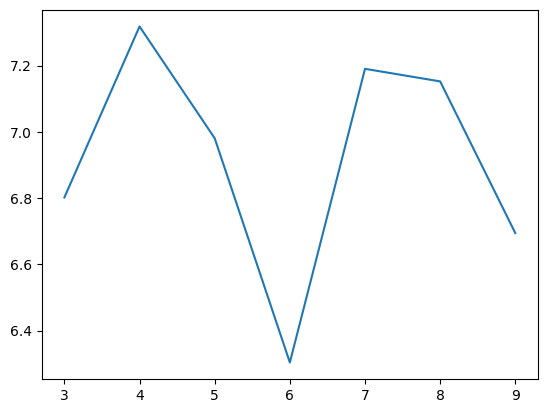

In [94]:
plt.figure() 
plt.plot(memory_lengths, percentage_errors)
plt.show()